In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from dataset import Dataset

class HingeLoss(nn.Module):
    def __init__(self,margin = 1):
        super(HingeLoss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        loss = torch.max(torch.tensor(0.), self.margin - inputs * targets)
        return loss.mean()

In [58]:
class DynamicScalarized(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size, margin = 1, gamma = 1.1, N = 2):
        super(DynamicScalarized, self).__init__()
        self.ort_base = None
        self.lr = 1e-4
        # self.loss = HingeLoss(margin)
        self.loss = torch.nn.BCEWithLogitsLoss()
        
        self.W1 = torch.nn.Linear(input_size, hidden_size) 
        self.Wmid = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.optimizer = torch.optim.SGD(self.parameters(), lr = self.lr)
        self.N = N
        self.gamma = gamma
        self.a = [1/self.N for i in range(self.N)]
# --------------------------------------------

    def forward(self, x):
        k = self.W1(x)
        z = F.relu(k)
        j = self.Wmid(z)
        x = F.relu(j)
        y = self.W2(z)
        
        return y
        
    def reset(self):
        self.a = [1/self.N for i in range(self.N)]

    def train(self, dl):
        class_1 = 1
        class_0 = 0
        l1 = []
        l2 = []
        for x,y in dl:
            # Vedo quanto sarebbe il gradiente di L1 ora
            y_pred_1 = self(x[y == class_1])
            y_target_1 = y.unsqueeze(1)[y.unsqueeze(1) == class_1]
            y_pred_1[y_pred_1 >= 0.99] = 1

            y_pred_2 = self(x[y == class_0])
            y_target_2 = y.unsqueeze(1)[y.unsqueeze(1) == class_0]
            y_pred_2[y_pred_2 <= -0.99] = 0
            
            tempL1 = self.loss(y_pred_1.view(-1), y_target_1)
            tempL2 = self.loss(y_pred_2.view(-1), y_target_2)

            eL1 = self.a[0] * self.loss(y_pred_1.view(-1), y_target_1)
            eL2 = self.a[1] * self.loss(y_pred_2.view(-1), y_target_2)

            eL1.backward(retain_graph = True)
            eL2.backward()

            self.optimizer.step()
            l1.append(tempL1.detach().numpy())
            l2.append(tempL2.detach().numpy())

        self.decrease_last(self.a)

        return sum(l1)/len(l1), sum(l2)/len(l2)

    def decrease_last(self, a):
        i = 1

        while self.a[-i] == 0:
            i += 1
            if i == self.N:
                return self.a

        if self.a[-i] / self.gamma < 1e-3:
            fact = self.a[-i]
            self.a[-i] = 0
        else :
            fact = self.a[-i]
            self.a[-i] /= self.gamma
            fact -= a[-i]

        for j in range(self.N-i):
            self.a[j] +=  fact/(self.N-i)
        if self.a[0] > 1:
            self.a[0] = 1
        return self.a

In [59]:
torch.manual_seed(1711)
modello = DynamicScalarized(2, 1, 1024, gamma = 1.01)
ds = Dataset(8)
dl = ds.get_dataloader()

100%|██████████| 450/450 [00:11<00:00, 38.11it/s]


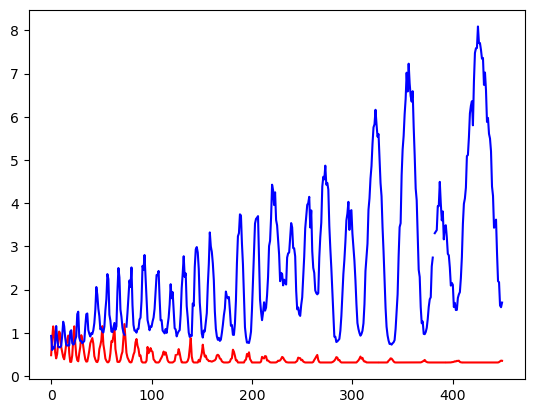

In [60]:
e = 1
err1 = []
err2 = []

# while e > 1e-4:
modello.reset()
for i in tqdm(range(450)):
    e1, e2 = modello.train(dl) # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err1.append(e1) 
    err2.append(e2)

plt.plot([x for x in range(len(err1))], err1, label = "Loss1", c = 'red')
plt.plot([x for x in range(len(err2))], err2, label = "Loss2", c = 'blue')
plt.show()

In [61]:
modello.a

[0.9943199546634017, 0.005680045336597559]

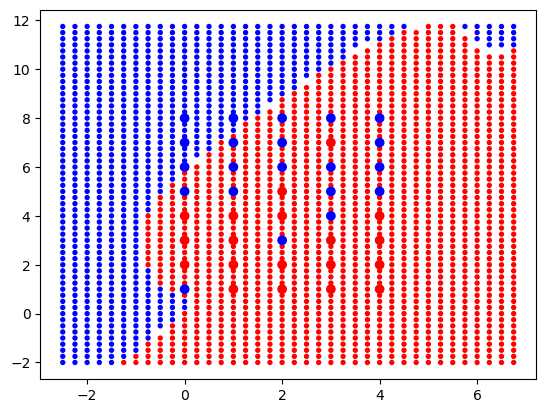

In [62]:
#PLOT FASE 2

for _ in range(10):
    modello.train(dl)

dataset = ds.dataset
labels = ds.labels

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] <= 0.4 else 'red' if p[2][0] >= 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione